In [25]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Process dataset
Extract data from the txt file for each user. We only extract the data for the time frame where the user is doing one action, not across different actions. Then we segment the data into 2 seconds window.

In [26]:
# file loader
def load_data(file):
    data = pd.read_csv(file, header=None, delim_whitespace = True)
    return data.values

In [27]:
N_classes = 4
window_size = 100   # 50Hz, 100 samples = 2s of movement
classes = ('WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 
            'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 
            'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND')[:N_classes]


def load_dataset(data_dir):
    raw_labels = open(data_dir + "/labels.txt", "r")
    dataset_x = []
    dataset_y = []
    current_exp, current_user = 0, 0
    acc_current_file_lines = []
    gyro_current_file_lines = []
    for line in raw_labels:
        # get the experiment and user data
        line_split = list(map(int,line.split()))

        # filter out the transition movements
        if line_split[2] > N_classes:
            continue

        # open new file if the current experiment and user are different from the previous run
        if line_split[0] != current_exp or line_split[1] != current_user:
            current_exp, current_user = line_split[0], line_split[1]

            # Get the accelerometer data
            # with open(data_dir + "/acc_exp" + str.zfill(str(current_exp), 2) + "_user" + str.zfill(str(current_user), 2) + ".txt", "r") as accelerometer_file:
            #     # print("Opened file: " + current_file.name)
            #     acc_current_file_lines = []
            #     for file_line in accelerometer_file:
            #         acc_current_file_lines.append(list(map(float, file_line.split())))
            acc_file_name = data_dir + "/acc_exp" + str.zfill(str(current_exp), 2) + "_user" + str.zfill(str(current_user), 2) + ".txt"
            acc_current_file_lines = load_data(acc_file_name)

            # Get the gyro data
            # with open(data_dir + "/gyro_exp" + str.zfill(str(current_exp), 2) + "_user" + str.zfill(str(current_user), 2) + ".txt", "r") as gyroscope_file:
            #     # print("Opened file: " + current_file.name)
            #     gyro_current_file_lines = []
            #     for file_line in gyroscope_file:
            #         gyro_current_file_lines.append(list(map(float, file_line.split())))
            gyro_file_name = data_dir + "/gyro_exp" + str.zfill(str(current_exp), 2) + "_user" + str.zfill(str(current_user), 2) + ".txt"
            gyro_current_file_lines = load_data(gyro_file_name)
            
        
        # get the label, start and end indices
        label, start, end = line_split[2:5]
        label -= 1 # convert to 0-indexed

        # sliding window
        for i in range(start, end - window_size, window_size):
            # calculate fft for the window
            acc_window = acc_current_file_lines[i:i+window_size]
            gyro_window = gyro_current_file_lines[i:i+window_size]
            inputs = np.concatenate((acc_window, gyro_window), axis=1)
            inputs = np.float32(np.transpose(inputs))
            dataset_x.append(inputs)
            dataset_y.append(label)

    raw_labels.close()

    print("Dataset initialized with size: " + str(len(dataset_y)))
    for i in range(N_classes):
        print("Class " + str(i) + " has " + str(dataset_y.count(i)) + " samples")
    
    dataset_y = to_categorical(dataset_y)
    return np.array(dataset_x), np.array(dataset_y)
dataset_x, dataset_y = load_dataset("HAPT Data Set/RawData")
train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.2, random_state=42)

Dataset initialized with size: 4429
Class 0 has 1161 samples
Class 1 has 1078 samples
Class 2 has 979 samples
Class 3 has 1211 samples


In [56]:
model = Sequential()
model.add(Conv1D(16, 20, activation='relu', input_shape=(6, 100), data_format='channels_first'))
model.add(Dropout(0.5)) # 50% dropout
# model.add(Conv1D(32, 40, activation='relu', data_format='channels_first'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(N_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# checkpoint callback
checkpoint_filepath = "model_checkpoint/"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# learning rate reduce on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Train the model
def train_network(model, train_x, train_y, test_x, test_y):
    verbose = 1 # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
    epochs = 100
    batch_size = 32
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), callbacks = [model_checkpoint_callback, reduce_lr, early_stopping], verbose=verbose)
    _, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
    return model

model = train_network(model, train_x, train_y, test_x, test_y)

Epoch 1/100
  1/111 [..............................] - ETA: 31s - loss: 1.4288 - accuracy: 0.2500

2022-09-04 13:42:03.816448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.7127

2022-09-04 13:42:05.212242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 2s 14ms/step - loss: 0.6909 - accuracy: 0.7127 - val_loss: 0.3277 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 1s 13ms/step - loss: 0.2546 - accuracy: 0.9159 - val_loss: 0.1736 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 1s 12ms/step - loss: 0.1368 - accuracy: 0.9633 - val_loss: 0.0794 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 1s 11ms/step - loss: 0.0889 - accuracy: 0.9752 - val_loss: 0.0562 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 5/100
111/111 [==============================] - 1s 11ms/step - loss: 0.0593 - accuracy: 0.9845 - val_loss: 0.0489 - val_accuracy: 0.9842 - lr: 0.0010
Epoch 6/100
111/111 [==============================] - 1s 12ms/step - loss: 0.0392 - accuracy: 0.9884 - val_loss: 0.0298 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 7/100
111/111 [==============================] - 1s 12ms/step - 

# Draw confusion matrix

2022-09-04 13:42:57.266434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Text(32.09374999999999, 0.5, 'Predicted')

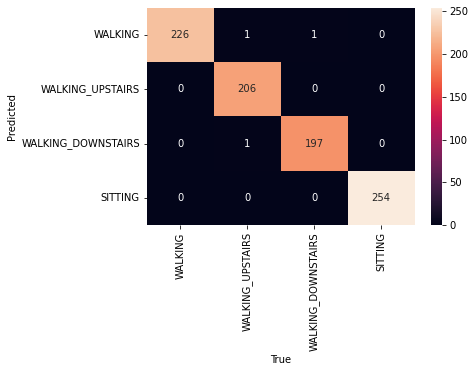

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.load_weights(checkpoint_filepath)
y_prediction = np.argmax(model.predict(test_x), axis=1)
result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("True")
plt.ylabel("Predicted")


In [58]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 16, 81)            1936      
                                                                 
 dropout_13 (Dropout)        (None, 16, 81)            0         
                                                                 
 flatten_13 (Flatten)        (None, 1296)              0         
                                                                 
 dense_26 (Dense)            (None, 16)                20752     
                                                                 
 dense_27 (Dense)            (None, 4)                 68        
                                                                 
Total params: 22,756
Trainable params: 22,756
Non-trainable params: 0
_________________________________________________________________
